In [1]:
# %load_ext dotenv
# %dotenv
from citymobil_python_clickhouse_wrapper import ClickHouseWrapper
import pandas as pd
import numpy as np
import os
import sys
import logging
import matplotlib.pyplot as plt
# import matplotlib
import pyexasol
import datetime as dt
import json

%matplotlib inline

In [2]:
import h3
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
import folium 
import matplotlib.colors as c
from matplotlib import cm

In [3]:
def getladder(ladder):
    res = {}
    val = 0
    for i in list(range(0,66)):
        try:
            val = ladder[str(i)]
        except: 
            pass
        res[i] = val
    return res

In [4]:
connect = pyexasol.connect(dsn='ex1..3.city-srv.ru:8563', 
                           user='F.BRYUKHOVETSKIY', 
                           password='igyvea-mO-coNks', 
                           fetch_dict=True)

In [5]:
# initialize connect to ClickHouse
logger = logging.getLogger()
clickhouse = ClickHouseWrapper(
    logger,
#     url="http://192.168.49.153:8123",
    url="http://chmain-vip.local.city-dt.ru:8123",
    user='F.BRYUKHOVETSKIY',
    password='igyvea-mO-coNks',
    create_and_assign_event_loop=False,  # for django threads with no event loop
    allow_nested_event_loops=True  # for jupyter threads with existed event loop
)


# Модель RFM

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics as metrics
# import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import matplotlib 

In [7]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("always")

In [8]:
connect = pyexasol.connect(dsn='ex1..3.city-srv.ru:8563', 
                           user='F.BRYUKHOVETSKIY', 
                           password='igyvea-mO-coNks', 
                           fetch_dict=True)

In [9]:
pd.options.display.max_rows = 999

In [10]:
pd.options.display.max_columns = 999

### Выгрузка старых сетапов

In [11]:
sql_all_mfg = '''
select id,
       d.ID_LOCALITY,
       JSON_VALUE(REPLACE(REPLACE(d.STAIRS,'[',''),']',''), '$.steps.json()')  as stairs
from REPLICA.DRIVER_SURCHARGE_LIST d
where 1=1
  and d.ACTIVE = 1
  and d.ID_LOCALITY = 22534
and d.DATE_START > now() - 220
and d.DATE_START < now() - 30

'''

In [12]:
all_ladder = pd.DataFrame(connect.execute(sql_all_mfg).fetchall())


In [13]:
all_ladder = all_ladder[~all_ladder['STAIRS'].isna()]
all_ladder['LADDER'] = all_ladder['STAIRS'].apply(lambda x: getladder(json.loads(x)))
all_mfg_ladder = all_ladder[['ID', 'LADDER']]
all_mfg_ladder.columns = ['SURCHARGE_ID', 'LADDER']
all_mfg_ladder

,SURCHARGE_ID,LADDER
0,4559,"{0: 0, 1: 140, 2: 280, 3: 420, 4: 560, 5: 700,..."
1,4563,"{0: 0, 1: 160, 2: 320, 3: 480, 4: 640, 5: 800,..."
2,4567,"{0: 0, 1: 160, 2: 320, 3: 480, 4: 640, 5: 800,..."
3,4571,"{0: 0, 1: 140, 2: 280, 3: 420, 4: 560, 5: 700,..."
4,4639,"{0: 0, 1: 170, 2: 340, 3: 510, 4: 640, 5: 850,..."
5,4643,"{0: 0, 1: 190, 2: 380, 3: 570, 4: 770, 5: 950,..."
6,4915,"{0: 0, 1: 220, 2: 440, 3: 660, 4: 890, 5: 1110..."
7,4919,"{0: 0, 1: 200, 2: 400, 3: 600, 4: 810, 5: 1010..."
8,5383,"{0: 0, 1: 190, 2: 370, 3: 560, 4: 700, 5: 930,..."
9,5387,"{0: 0, 1: 210, 2: 420, 3: 630, 4: 850, 5: 1050..."


### Выгрузка исходных данных для обучения

In [14]:
sql_mfg_drivers = '''
with lad as

(select d."DATE", d.DRIVER_ID,
        SURCHARGE_ID,
        case when sl.IDS_PRIORITY_LEVEL = '3' then 1 else 0 end is_brand,
         coalesce(rfm.SEGMENT_ID, -1) as SEGMENT_ID, d.ORDERS_COUNT, d.DRIVER_BILL, d.EXPECTED_SUM, d.FEE
from REPLICA.driver_surcharge_payments d
LEFT JOIN REPLICA.DRIVER_SEGMENTATION_RFM rfm on rfm."DATE" = d."DATE" and rfm.DRIVER_ID = d.DRIVER_ID
LEFT JOIN REPLICA.DRIVER_SURCHARGE_LIST sl on sl.ID = d.SURCHARGE_ID
where 1=1
-- and d.SURCHARGE_ID = 6803
-- and d."DATE" BETWEEN '2021-09-10' and '2021-09-28'
  and sl.ID_LOCALITY = 22534
and d."DATE" BETWEEN '2021-06-28' and '2021-10-04'
-- order by d."DATE"
    )

, long_trips as (
select "DATE"
     , DRIVER_ID
     , count(distinct o.ORDER_RK) as trips
     , count(distinct case when o.EXP_DIST_KM > 6 then o.ORDER_RK else null end) as long_trips
     , count(distinct case when o.EXP_DIST_KM > 6 then o.ORDER_RK else null end) / count(distinct o.ORDER_RK) as share_long_trips_driver
from REPLICA.DRIVER_SURCHARGE_ORDERS so
join EMART."ORDER" o on so.ORDER_ID = o.ORDER_RK and so.DRIVER_ID = o.DRIVER_RK
where 1=1
  and o.LOCALITY_RK = 22534
  and so."DATE" BETWEEN '2021-06-28' and '2021-10-04'
group by 1,2
)

,avg_market as (
    select to_date(oc.ORDEREDDATE) as "DATE"
           , avg(oc.EXP_PRICE) as avg_price
           , avg(case when oc.EXP_DISTANCE > 6 then oc.EXP_PRICE end) as avg_price_long
           , avg(case when oc.EXP_DISTANCE <= 6 then oc.EXP_PRICE end) as avg_price_short
--             , avg( oc.EXP_PRICE_FOR_DRIVER) as avg_price_driver
--            , avg(case when oc.EXP_DISTANCE > 6 then oc.EXP_PRICE_FOR_DRIVER end) as avg_price_driver_long
--            , avg(case when oc.EXP_DISTANCE <= 6 then oc.EXP_PRICE_FOR_DRIVER end) as avg_price_driver_short
            , avg(case when oc.DRIVER_BILL > 0 then oc.DRIVER_BILL end) as avg_price_driver
           , avg(case when oc.DRIVER_BILL > 0 and oc.EXP_DISTANCE > 6 then oc.DRIVER_BILL end) as avg_price_driver_long
           , avg(case when oc.DRIVER_BILL > 0 and oc.EXP_DISTANCE <= 6 then oc.DRIVER_BILL end) as avg_price_driver_short
--           , avg(case when oc.status = 'CP' and oc.EXP_DISTANCE > 6 then oc.EXP_PRICE_FOR_DRIVER else null end) / avg(case when oc.status = 'CP' and oc.EXP_DISTANCE > 6 then oc.EXP_PRICE else null end) as share_price_long
--         , avg(case when oc.status = 'CP' and oc.EXP_DISTANCE <= 6 then oc.EXP_PRICE_FOR_DRIVER else null end) / avg(case when oc.status = 'CP' and oc.EXP_DISTANCE <= 6 then oc.EXP_PRICE else null end) as share_price_short
         , count(oc.id) as orders
         , count(case when oc.status = 'CP' then oc.id else null end) as rides
            , count(distinct oc.DRIVER) as active_drivers
           , count(case when oc.EXP_DISTANCE > 6 then oc.id else null end) / count(*) as share_long
           , count(case when oc.status = 'CP' and oc.EXP_DISTANCE > 6 then oc.id else null end) / count(case when oc.status = 'CP' then oc.id else null end) as share_long_trips
--             , count(case when oc.STATUS = 'CP' then oc.id end) / count(oc.id) as o2r
            , sum(case when CLIENT_BILL_AMT > 0 then CLIENT_BILL_AMT else 1 end) as gmv
            , (sum(COMMISSION_TOTAL_AMT) - SUM(
            CI_CLIENT_REJECT + CI_COUPONS + CI_DISCOUNT_FOR_NEW_CLIENTS + CI_DISCOUNT_OTHER + CI_HR +
            CI_LOYALITY_PROGRAM_BONUS + CI_MAIL_COMBO + CI_MAIL_SPECIAL + CI_OLD_BONUS +
            --CI_PAID_BY_BONUS_POINTS +
            CI_PAID_PARTNER + CI_POTENTIAL + CI_PUSH_DISCOUNT + CI_SBER_PRIME + CI_SBER_SPASIBO_BONUS +
            DI_MOMENTAL) - SUM(di_mfg + di_welcome_dxgy + di_power_dxgy + di_other_dxgy + di_main_dxgy
    + di_guaranteed_amt_per_hour + di_geo_minimal_amt + di_gold_minimal_amt
    + di_base_minimal_amt + di_silver_minimal_amt + di_other_incentives_amt)) as cotnribution
, (sum(COMMISSION_TOTAL_AMT) - SUM(
            CI_CLIENT_REJECT + CI_COUPONS + CI_DISCOUNT_FOR_NEW_CLIENTS + CI_DISCOUNT_OTHER + CI_HR +
            CI_LOYALITY_PROGRAM_BONUS + CI_MAIL_COMBO + CI_MAIL_SPECIAL + CI_OLD_BONUS +
            --CI_PAID_BY_BONUS_POINTS +
            CI_PAID_PARTNER + CI_POTENTIAL + CI_PUSH_DISCOUNT + CI_SBER_PRIME + CI_SBER_SPASIBO_BONUS +
            DI_MOMENTAL) - SUM(di_mfg + di_welcome_dxgy + di_power_dxgy + di_other_dxgy + di_main_dxgy
    + di_guaranteed_amt_per_hour + di_geo_minimal_amt + di_gold_minimal_amt
    + di_base_minimal_amt + di_silver_minimal_amt + di_other_incentives_amt)) /
    sum(case when CLIENT_BILL_AMT > 0 then CLIENT_BILL_AMT else 1 end)        as cotnribution_gmv
    from REPLICA.ORDER_CLOSED oc
        LEFT JOIN REPLICA_MART.INCENTIVE_COMISSION ic on oc.id = ic.ORDER_ID
        where 1=1
        and oc.MAIN_ID_LOCALITY = 22534
--         and to_date(oc.ORDEREDDATE) BETWEEN '2021-09-10' and '2021-09-28'
        and to_date(oc.ORDEREDDATE) BETWEEN '2021-06-28' and '2021-10-04'
    GROUP BY 1
)

select l.*, am.orders, am.active_drivers, am.share_long, am.share_long_trips, lt.share_long_trips_driver,
       --am.gmv, am.cotnribution, am.cotnribution_gmv,
       am.gmv, am.rides,
        am.avg_price, am.avg_price_long, am.avg_price_short,
       am.avg_price_driver, am.avg_price_driver_long, am.avg_price_driver_short
FROM lad l
LEFT JOIN long_trips lt on lt.DRIVER_ID = l.DRIVER_ID and lt."DATE" = l."DATE"
LEFT JOIN avg_market am on am."DATE" = l."DATE"
'''

In [15]:
# ladder_seg = 6799
# ladder_seg = 6803

In [16]:
mfg_d = pd.DataFrame(connect.execute(sql_mfg_drivers).fetchall())
mfg_d = mfg_d[~mfg_d['DRIVER_BILL'].isna()]
mfg_d['DRIVER_BILL'] = np.float64(mfg_d['DRIVER_BILL'])
mfg_d['GMV'] = np.float64(mfg_d['GMV'])

# mfg_d['PREV_STEP_DELTA'] = abs(mfg_d['EXPECTED_SUM'] - mfg_d['ORDERS_COUNT'].apply(lambda x: ladder_map[x-1]))
# mfg_d['NEXT_STEP_DELTA'] = abs(mfg_d['EXPECTED_SUM'] - mfg_d['ORDERS_COUNT'].apply(lambda x: ladder_map[x+1]))
mfg_d['DATE'] = pd.to_datetime(mfg_d['DATE'])

In [60]:
# mfg_d.columns
mfg_d.sort_values(by='DATE')

,DATE,DRIVER_ID,SURCHARGE_ID,IS_BRAND,SEGMENT_ID,ORDERS_COUNT,DRIVER_BILL,EXPECTED_SUM,FEE,ORDERS,ACTIVE_DRIVERS,SHARE_LONG,SHARE_LONG_TRIPS,SHARE_LONG_TRIPS_DRIVER,GMV,RIDES,AVG_PRICE,AVG_PRICE_LONG,AVG_PRICE_SHORT,AVG_PRICE_DRIVER,AVG_PRICE_DRIVER_LONG,AVG_PRICE_DRIVER_SHORT
44990,2021-06-28,21480259,5383,0,4,20,3952.0,4000,48,15288,831,0.452054,0.399587,0.250000,1471621.0,8236,202.326596,266.639850,149.268354,203.860605,251.749774,171.873492
55185,2021-06-28,18938631,5383,0,4,16,2882.0,3150,268,15288,831,0.452054,0.399587,0.625000,1471621.0,8236,202.326596,266.639850,149.268354,203.860605,251.749774,171.873492
55090,2021-06-28,15816255,5387,1,4,15,2515.0,3250,735,15288,831,0.452054,0.399587,0.600000,1471621.0,8236,202.326596,266.639850,149.268354,203.860605,251.749774,171.873492
39011,2021-06-28,25771027,5387,1,-1,3,629.0,630,1,15288,831,0.452054,0.399587,0.000000,1471621.0,8236,202.326596,266.639850,149.268354,203.860605,251.749774,171.873492
55088,2021-06-28,14160702,5383,0,0,1,350.0,190,0,15288,831,0.452054,0.399587,0.000000,1471621.0,8236,202.326596,266.639850,149.268354,203.860605,251.749774,171.873492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66170,2021-10-04,30903815,6975,0,-1,5,975.0,845,0,8699,635,0.554776,0.511334,0.800000,936651.0,5294,192.959651,239.616038,134.822876,184.221993,221.274725,145.301654
55872,2021-10-04,22573787,6975,0,3,2,492.0,325,0,8699,635,0.554776,0.511334,1.000000,936651.0,5294,192.959651,239.616038,134.822876,184.221993,221.274725,145.301654
55873,2021-10-04,24868891,6975,0,4,7,1202.0,1250,48,8699,635,0.554776,0.511334,0.571429,936651.0,5294,192.959651,239.616038,134.822876,184.221993,221.274725,145.301654
73958,2021-10-04,16375895,6975,0,4,5,1160.0,845,0,8699,635,0.554776,0.511334,0.800000,936651.0,5294,192.959651,239.616038,134.822876,184.221993,221.274725,145.301654


## Обучающая выборка

In [18]:
mfg = mfg_d.groupby(['SURCHARGE_ID','DATE', 'SEGMENT_ID', 'ORDERS_COUNT','SHARE_LONG', 'IS_BRAND',#'PREV_STEP_DELTA', 'NEXT_STEP_DELTA',
                      'RIDES','GMV','AVG_PRICE_LONG', 'AVG_PRICE_SHORT', 'ORDERS', 'ACTIVE_DRIVERS','EXPECTED_SUM',#'AVG_PRICE_DRIVER',#'AVG_PRICE',
                      'AVG_PRICE_DRIVER_SHORT','AVG_PRICE_DRIVER_LONG']).aggregate({'DRIVER_ID':'count', 
                                                                                    'FEE':'sum',
                                                                                     'SHARE_LONG_TRIPS_DRIVER':'mean',
                                                                                    'DRIVER_BILL':'mean'}).reset_index()
mfg['IS_WEEKEND'] = mfg.DATE.dt.dayofweek.apply(lambda x: 1 if x in [5,6] else 0)
# data_0['IS_WEEKEND'] = data_0.DATE.dt.dayofweek


In [65]:
mfg

,SURCHARGE_ID,DATE,SEGMENT_ID,ORDERS_COUNT,SHARE_LONG,IS_BRAND,RIDES,GMV,AVG_PRICE_LONG,AVG_PRICE_SHORT,ORDERS,ACTIVE_DRIVERS,EXPECTED_SUM,AVG_PRICE_DRIVER_SHORT,AVG_PRICE_DRIVER_LONG,DRIVER_ID,FEE,SHARE_LONG_TRIPS_DRIVER,DRIVER_BILL,IS_WEEKEND
0,5383,2021-06-28,-1,1,0.452054,0,8236,1471621.0,266.639850,149.268354,15288,831,190,171.873492,251.749774,13,462,0.538462,264.538462,0
1,5383,2021-06-28,-1,2,0.452054,0,8236,1471621.0,266.639850,149.268354,15288,831,370,171.873492,251.749774,10,0,0.650000,570.000000,0
2,5383,2021-06-28,-1,3,0.452054,0,8236,1471621.0,266.639850,149.268354,15288,831,560,171.873492,251.749774,5,336,0.133333,629.200000,0
3,5383,2021-06-28,-1,4,0.452054,0,8236,1471621.0,266.639850,149.268354,15288,831,700,171.873492,251.749774,6,0,0.541667,917.500000,0
4,5383,2021-06-28,-1,5,0.452054,0,8236,1471621.0,266.639850,149.268354,15288,831,930,171.873492,251.749774,3,136,0.533333,884.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20985,6979,2021-10-04,4,27,0.554776,1,5294,936651.0,239.616038,134.822876,8699,635,5400,145.301654,221.274725,3,3014,0.518519,4395.333333,0
20986,6979,2021-10-04,4,30,0.554776,1,5294,936651.0,239.616038,134.822876,8699,635,6250,145.301654,221.274725,1,380,0.400000,5870.000000,0
20987,6979,2021-10-04,4,32,0.554776,1,5294,936651.0,239.616038,134.822876,8699,635,6700,145.301654,221.274725,1,1931,0.406250,4769.000000,0
20988,6979,2021-10-04,4,34,0.554776,1,5294,936651.0,239.616038,134.822876,8699,635,7100,145.301654,221.274725,1,2041,0.470588,5059.000000,0


In [19]:
brand_dict = mfg[['SURCHARGE_ID', 'IS_BRAND']].drop_duplicates().set_index('SURCHARGE_ID').to_dict()['IS_BRAND']

In [20]:
day_data = mfg[['DATE', 'IS_WEEKEND', 'SHARE_LONG', 'AVG_PRICE_LONG', 'AVG_PRICE_SHORT','ORDERS','RIDES','GMV',
                'ACTIVE_DRIVERS', 'AVG_PRICE_DRIVER_SHORT','AVG_PRICE_DRIVER_LONG' ]].drop_duplicates()
step_data = mfg[['DATE','SURCHARGE_ID', 'SEGMENT_ID', 'ORDERS_COUNT', 'IS_BRAND', # 'PREV_STEP_DELTA', 'NEXT_STEP_DELTA', 
                    'EXPECTED_SUM', 'DRIVER_ID', 'FEE', 'SHARE_LONG_TRIPS_DRIVER', 'DRIVER_BILL']].copy()


### Генерирую полные данные для обучения (с учетом ступеней, на которых никого не было)

In [78]:
#Всевозможные комбинации даты, кампаний, сегментов, шагов
d = pd.DataFrame(data = {'DATE':mfg['DATE'].unique(), 'key':[1]*len(mfg['DATE'].unique())})
d = d.merge(pd.DataFrame(data = {'SURCHARGE_ID':mfg['SURCHARGE_ID'].unique(), 'key':[1]*len(mfg['SURCHARGE_ID'].unique())}), how='outer', on='key')
d = d.merge(pd.DataFrame(data = {'SEGMENT_ID':mfg['SEGMENT_ID'].unique(), 'key':[1]*len(mfg['SEGMENT_ID'].unique())}), how='outer', on='key')
d = d.merge(pd.DataFrame(data = {'ORDERS_COUNT':list(range(1,62)), 'key':[1]*61}), how='outer', on='key')
d['IS_BRAND'] = d['SURCHARGE_ID'].apply(lambda x: brand_dict[x])
d.drop(labels ='key',axis=1, inplace = True)

In [79]:
d = d.merge(day_data, how='left', on = 'DATE', suffixes=('', '_YYYY'))
d = d.merge(all_mfg_ladder[all_mfg_ladder['SURCHARGE_ID'].isin(list(brand_dict.keys()))], how='inner', on='SURCHARGE_ID', suffixes=('', '_YYYY'))
d = d.merge(step_data, how='left', on = ['DATE', 'SURCHARGE_ID', 'SEGMENT_ID', 'ORDERS_COUNT', 'IS_BRAND'], suffixes=('', '_YYYY'))

#выплата по ступеньке по сетапу, выплата по предыдущей и следующей ступеньке
d['EXPECTED_SUM'] = d.apply(lambda x: x['LADDER'][x['ORDERS_COUNT']], axis = 1)
d['PREV_STEP_DELTA'] = abs(d['EXPECTED_SUM'] - d.apply(lambda x: x['LADDER'][x['ORDERS_COUNT']-1], axis = 1))
d['NEXT_STEP_DELTA'] = abs(d['EXPECTED_SUM'] - d.apply(lambda x: x['LADDER'][x['ORDERS_COUNT']+1], axis = 1))
d.fillna(0, inplace=True)

#"Активные" кампании-дни - только те, в которых более 50 водителей
active_mfg = d.groupby(['SURCHARGE_ID', 'DATE'])['DRIVER_ID'].sum().reset_index()
active_mfg['IS_ACTIVE'] = active_mfg['DRIVER_ID'].apply(lambda x: 1 if x > 50 else 0)
active_mfg = active_mfg[active_mfg['IS_ACTIVE']==1][['SURCHARGE_ID', 'DATE']]

d = d.merge(active_mfg, how='inner', on=['SURCHARGE_ID', 'DATE'], suffixes=('', '_YYYY'))
d['SUM_ORDERS_STEP'] = d['ORDERS_COUNT'] * d['DRIVER_ID']
#Водители охотнее добегают до ступеней с круглой суммой
d['IS_ATTRACTIVE'] = np.int64((d['EXPECTED_SUM']%500<100) | (d['EXPECTED_SUM']%500>400))

### Прогноз структуры заказов на ступене

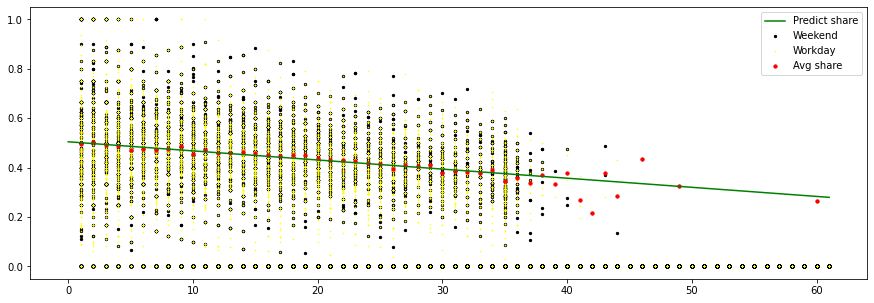

In [23]:
#среднее значение доли длинных поездок по водителям на ступеньке
df_share = d[d.DRIVER_ID != 0].groupby(['ORDERS_COUNT'])['SHARE_LONG_TRIPS_DRIVER'].mean().reset_index()

m2 = LinearRegression()
m2.fit(np.array(d[d.DRIVER_ID != 0]['ORDERS_COUNT']).reshape(-1, 1), d[d.DRIVER_ID != 0]['SHARE_LONG_TRIPS_DRIVER'])

# poly = PolynomialFeatures(degree=1)
# poly.fit_transform(np.array(d[d.DRIVER_ID != 0]['ORDERS_COUNT']).reshape(-1, 1))
# m2.fit(poly.transform(np.array(d[d.DRIVER_ID != 0]['ORDERS_COUNT']).reshape(-1, 1)), d[d.DRIVER_ID != 0]['SHARE_LONG_TRIPS_DRIVER'])


plt.figure(figsize = (15,5))
plt.scatter(d[d['IS_WEEKEND']>=1]['ORDERS_COUNT'], d[d['IS_WEEKEND']>=1]['SHARE_LONG_TRIPS_DRIVER'], s=5.3,  color = 'black', label = 'Weekend')
plt.scatter(d[d['IS_WEEKEND']<1]['ORDERS_COUNT'], d[d['IS_WEEKEND']<1]['SHARE_LONG_TRIPS_DRIVER'], s=0.3, color = 'yellow', label = 'Workday')

plt.scatter(df_share['ORDERS_COUNT'], df_share['SHARE_LONG_TRIPS_DRIVER'], s=10.9, color = 'red', label ='Avg share')
plt.plot(np.array(range(0,62)), m2.predict(np.array(range(0,62)).reshape(-1,1)), color = 'green', label = 'Predict share');

# plt.plot(np.array(range(0,62)), m2.predict(poly.transform(np.array(range(0,62)).reshape(-1,1))), color = 'green')
plt.legend();


### Выкинул дни с даунтаймами/багами в DI и оставил день для контроля

In [24]:
data_control_0 = d[d['DATE']>='2021-09-28']
data_0 = d[(d['DATE']<'2021-09-28') 
           & (~d['DATE'].isin(['2021-07-31','2021-08-01','2021-08-02']))
#            & (~d['DATE'].isin(['2021-09-29','2021-09-30','2021-10-01','2021-10-02','2021-10-03','2021-10-04']))
          ]

In [25]:
columns_list = ['ORDERS_COUNT', 'EXPECTED_SUM','IS_ATTRACTIVE', # 'PREV_STEP_DELTA', 
                                                'NEXT_STEP_DELTA', 
                                              'IS_BRAND','SEGMENT_ID', 'IS_WEEKEND',
                                              'ORDERS', 'ACTIVE_DRIVERS', 
                                              'SHARE_LONG', 'AVG_PRICE_LONG', 'AVG_PRICE_SHORT']
columns_bill_list = ['ORDERS_COUNT', 'IS_WEEKEND',
                                              'ORDERS', 'ACTIVE_DRIVERS', 
                                              'SHARE_LONG', 'AVG_PRICE_LONG', 'AVG_PRICE_SHORT']

In [26]:
# parameters = {#'n_estimators': [100,200,300],
#               'max_features': [6,7,8], 
#               'min_samples_leaf': [5, 6, 7], 
# #               'max_depth': [8, 9, 10],
#               'min_samples_split':[2, 3, 4]}
# rfc = RandomForestClassifier(max_depth=9, random_state=42, n_jobs=-1, oob_score=True)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
# gcv.fit(x, y)
# print(gcv.best_estimator_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

RandomForestClassifier(max_depth=9, max_features=7, min_samples_leaf=6,
                       n_jobs=-1, oob_score=True, random_state=42)

  ROC-AUC = 0.893  Accuracy = 0.926  Precision = 0.883 [v.predict]


,ORDERS_COUNT,EXPECTED_SUM,IS_ATTRACTIVE,NEXT_STEP_DELTA,IS_BRAND,SEGMENT_ID,IS_WEEKEND,ORDERS,ACTIVE_DRIVERS,SHARE_LONG,AVG_PRICE_LONG,AVG_PRICE_SHORT,fact,predict
12765,17,3450,1,250,0,4,1,15005,717,0.540420,262.394993,147.169519,1,1.0
17496,51,8400,0,0,0,3,0,15218,899,0.490932,244.156204,120.010197,0,0.0
22011,52,8400,0,0,0,-1,0,11590,784,0.488438,232.091503,111.130882,0,0.0
43968,49,8350,0,0,1,-1,1,11902,617,0.478491,268.706585,147.220235,0,0.0
17128,49,8400,0,0,0,3,0,14746,893,0.527940,229.888889,113.949576,0,0.0
1114,17,3400,0,200,0,-1,0,14254,890,0.488424,235.846309,122.103401,1,1.0
47572,54,8000,1,0,0,4,0,12189,759,0.485684,250.733108,128.564364,0,0.0
51486,3,515,1,170,0,3,1,11902,617,0.478491,268.706585,147.220235,1,1.0
20389,16,3250,0,200,0,3,1,15051,703,0.518902,266.831370,152.575059,1,1.0
51908,59,8000,1,0,0,3,0,10672,709,0.458302,247.472909,129.912645,0,0.0


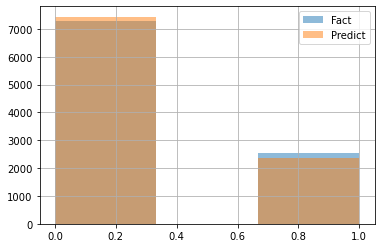

In [27]:
x, x_test, y, y_test = train_test_split(data_0[columns_list],
                                        data_0['DRIVER_ID'].apply(lambda x: 0 if x==0 else 1)
#                                         data_0['SUM_ORDERS_STEP']
                                        , test_size=0.2, random_state=42)

model_cl = RandomForestClassifier(n_estimators=200, max_depth=9, max_features=7, min_samples_leaf=6,
                       n_jobs=-1, oob_score=True, random_state=42) # драйвера



model_cl.fit(x, y)
predict = np.floor(model_cl.predict(x_test))
x_test['fact'] = y_test
x_test['predict'] = predict

for i in ['predict']:
    print( '',
          ' ROC-AUC =', np.round(metrics.roc_auc_score(x_test['fact'], x_test[i]),3),
          ' Accuracy =', np.round(metrics.accuracy_score(x_test['fact'], x_test[i]),3),
          ' Precision =', np.round(metrics.precision_score(x_test['fact'], x_test[i]),3),
          '[v.'+i+']')
x_test['fact'].hist(bins=3, label = 'Fact', alpha=0.5)
x_test['predict'].hist(bins=3, label = 'Predict', alpha=0.5);
plt.legend();

x_test.head(10)

In [28]:
# parameters = {#'n_estimators': [100,200,300],
#               'max_features': [8, 9, 10], 
#               'min_samples_leaf': [9, 10, 11], 
#               'max_depth': [4,5,6],
#               'min_samples_split':[4, 5, 6]}
# rfc = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
# gcv.fit(x, y)
# print(gcv.best_estimator_)

R2 = 0.729  MSE = 1235.961  MAPE = 0.493  MAE = 17.834 [v.predict]
R2 = 0.705  MSE = 1345.367  MAPE = 0.38  MAE = 17.117 [v.predict_2]
R2 = 0.711  MSE = 1317.65  MAPE = 0.672  MAE = 20.364 [v.predict_3]
R2 = 0.724  MSE = 1260.89  MAPE = 0.466  MAE = 17.237 [v.predict_4]


,ORDERS_COUNT,EXPECTED_SUM,IS_ATTRACTIVE,NEXT_STEP_DELTA,IS_BRAND,SEGMENT_ID,IS_WEEKEND,ORDERS,ACTIVE_DRIVERS,SHARE_LONG,AVG_PRICE_LONG,AVG_PRICE_SHORT,fact,predict,predict_2,predict_3,predict_4
35169,34,8000,1,750,1,-1,0,13548,790,0.432831,242.903138,136.828735,34.0,44.161483,34.0,68.0,34.0
12696,9,1710,0,240,0,3,1,15005,717,0.540420,262.394993,147.169519,45.0,38.325446,36.0,45.0,36.0
35093,19,4050,1,350,1,4,0,15742,797,0.480498,240.853649,130.281976,38.0,67.898528,57.0,76.0,76.0
3247,15,3150,0,200,0,4,1,15493,870,0.565352,238.728051,130.966736,30.0,68.709574,60.0,75.0,75.0
1039,3,560,1,140,0,4,0,14176,905,0.452666,245.544647,132.440005,18.0,12.476103,12.0,15.0,12.0


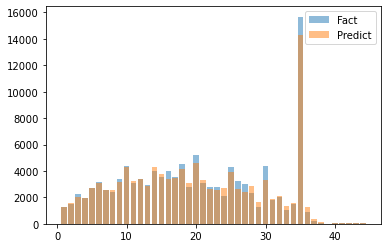

In [29]:
#кол-во заказов на ступеньке
x, x_test, y, y_test = train_test_split(data_0[(data_0['DRIVER_ID']>0) & (data_0['ORDERS_COUNT']<350)][columns_list],
#                                         data_0[(data_0['DRIVER_ID']>0) & (data_0['ORDERS_COUNT']<350)]['DRIVER_ID'] 
                                        data_0[(data_0['DRIVER_ID']>0) & (data_0['ORDERS_COUNT']<350)]['SUM_ORDERS_STEP']**1
                                        , test_size=0.2, random_state=12)

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, criterion='mse', random_state=42,
                              max_depth=20, max_features=9, min_samples_leaf=10, min_samples_split=5) # драйвера



model.fit(x, y)
predict = model.predict(x_test)
x_test['fact'] = y_test**1
x_test['predict'] = predict**1
x_test['predict_2'] = x_test['predict'] - x_test['predict']%x_test['ORDERS_COUNT']
x_test['predict_3'] = (x_test['predict'] + (x_test['ORDERS_COUNT'] - x_test['predict']%x_test['ORDERS_COUNT']))*x_test['predict'].apply(lambda x: 0 if x==0 else 1)
x_test['predict_4'] = x_test['ORDERS_COUNT']*np.round(x_test['predict']/x_test['ORDERS_COUNT'])

for i in ['predict','predict_2','predict_3','predict_4']:
    print('R2 =',np.round(metrics.r2_score(x_test['fact'], x_test[i]),3), 
          ' MSE =',np.round(metrics.mean_squared_error(x_test['fact'], x_test[i]),3), 
          ' MAPE =',np.round(metrics.mean_absolute_percentage_error(x_test[x_test['fact']>0]['fact'], x_test[x_test['fact']>0][i]),3), 
          ' MAE =', np.round(metrics.mean_absolute_error(x_test['fact'], x_test[i]),3), '[v.'+i+']')

drivers_agg = x_test[x_test.fact > 0].groupby(['ORDERS_COUNT'])[['fact','predict', 'predict_2', 'predict_3','predict_4']].sum().reset_index()

plt.bar(drivers_agg.ORDERS_COUNT, drivers_agg.fact, label = 'Fact', alpha=0.5, align='center')
plt.bar(drivers_agg.ORDERS_COUNT, drivers_agg.predict, label = 'Predict', alpha=0.5, align='center')
plt.legend();


x_test.head(5)

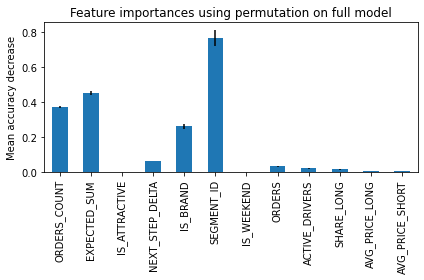

In [30]:
result = permutation_importance(
    model, x, y, n_repeats=10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=x.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [31]:
# parameters = {'n_estimators': [100,200,300],
#               'max_features': [8, 9, 10], 
#               'min_samples_leaf': [9, 10, 11], 
#               'max_depth': [4,5,6],
#               'min_samples_split':[4, 5, 6]}
# rfc = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
# gcv.fit(xx, yy)
# print(gcv.best_estimator_)

In [32]:
columns_bill_list

['ORDERS_COUNT',
 'IS_WEEKEND',
 'ORDERS',
 'ACTIVE_DRIVERS',
 'SHARE_LONG',
 'AVG_PRICE_LONG',
 'AVG_PRICE_SHORT']

R2 = 0.936  MSE = 189194.031  MAPE = 0.158  MAE = 289.569


,ORDERS_COUNT,IS_WEEKEND,ORDERS,ACTIVE_DRIVERS,SHARE_LONG,AVG_PRICE_LONG,AVG_PRICE_SHORT,fact,predict
42835,14,0,10627,729,0.472570,237.147551,112.149331,2308.333333,2506.0
19227,13,0,15742,797,0.480498,240.853649,130.281976,1537.000000,2438.0


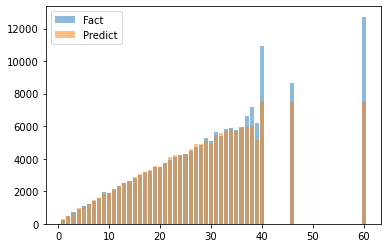

In [33]:
xx, x_test, yy, y_test = train_test_split(data_0[data_0['DRIVER_BILL']>0][columns_bill_list],
                                        data_0[data_0['DRIVER_BILL']>0]['DRIVER_BILL'] , test_size=0.2, random_state=13)

model_bill = RandomForestRegressor(n_estimators=100, 
                                   max_features = 6,  min_samples_leaf = 25, max_depth=5, min_samples_split=2, criterion='mse')


model_bill.fit(xx, yy)
predict = np.floor(model_bill.predict(x_test))
# print(metrics.r2_score(y_test, predict))
print('R2 =',np.round(metrics.r2_score(y_test, predict),3), 
          ' MSE =',np.round(metrics.mean_squared_error(y_test, predict),3), 
          ' MAPE =',np.round(metrics.mean_absolute_percentage_error(y_test, predict),3), 
          ' MAE =', np.round(metrics.mean_absolute_error(y_test, predict),3))

x_test['fact'] = y_test
x_test['predict'] = predict

bill_agg = x_test[x_test.fact > 0].groupby(['ORDERS_COUNT'])[['fact','predict']].mean().reset_index()

plt.bar(bill_agg.ORDERS_COUNT, bill_agg.fact, label = 'Fact', alpha=0.5, align='center')
plt.bar(bill_agg.ORDERS_COUNT, bill_agg.predict, label = 'Predict', alpha=0.5, align='center')
plt.legend();

x_test.head(2)

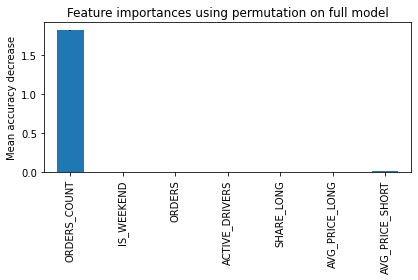

In [34]:
result = permutation_importance(
    model_bill, xx, yy, n_repeats=10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=xx.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [35]:
def get_ladder_from_dict(ladder):
    res = {}
    val = 0
    for i in list(range(0,62)):
        try:
            val = ladder[i]
        except: 
            pass
        res[i] = val
    return res

def generate_data(setup_ladder, ORDERS=13964, ACTIVE_DRIVERS=859, SHARE_LONG=0.4596, 
                  AVG_PRICE_LONG=245.0074, AVG_PRICE_SHORT=133.7162, AVG_PRICE_DRIVER_LONG=241.2746, AVG_PRICE_DRIVER_SHORT=158.5896):
    new_data = pd.DataFrame()
    for b in setup_ladder:
#         brand = b
        for s in setup_ladder[b]:
#             segment = s
            new_ladder = get_ladder_from_dict(setup_ladder[b][s])
            length = len(list(new_ladder.keys())[1:61])
            new_data = new_data.append(pd.DataFrame(data= {'ORDERS_COUNT':list(new_ladder.keys())[1:61],
                               'EXPECTED_SUM':list(new_ladder.values())[1:61], 
                               'PREV_STEP_DELTA':[abs(new_ladder[x] - new_ladder[x-1]) for x in list(new_ladder.keys())[1:61]],
                               'NEXT_STEP_DELTA':[abs(new_ladder[x] - new_ladder[x+1]) for x in list(new_ladder.keys())[1:61]],
                               'IS_BRAND':[b]*length,
                               'SEGMENT_ID':[s]*length,
                               'ORDERS':[ORDERS]*length,
                               'IS_WEEKEND':[1]*length,
                               'ACTIVE_DRIVERS':[ACTIVE_DRIVERS]*length,
                               'SHARE_LONG':[SHARE_LONG]*length,
                               'AVG_PRICE_LONG':[AVG_PRICE_LONG]*length,
                               'AVG_PRICE_SHORT':[AVG_PRICE_SHORT]*length,
                               'AVG_PRICE_DRIVER_LONG':[AVG_PRICE_DRIVER_LONG]*length,
                               'AVG_PRICE_DRIVER_SHORT':[AVG_PRICE_DRIVER_SHORT]*length
                                }), ignore_index=True)
    new_data['IS_ATTRACTIVE'] = np.int64((new_data['EXPECTED_SUM']%500<100) | (new_data['EXPECTED_SUM']%500>400))
    return new_data

In [36]:
def get_context(date = '2021-09-29'):
    context_sql = '''
    with ladder as

    (select d."DATE",
            median(d.DRIVER_BILL) as DRIVER_BILL,
            sum(d.FEE) as FEE,
            count(d.DRIVER_ID) as DRIVER_ID,
            sum(d.ORDERS_COUNT) / count(d.ORDERS_COUNT) as TPD
    from REPLICA.driver_surcharge_payments d
    LEFT JOIN REPLICA.DRIVER_SEGMENTATION_RFM rfm on rfm."DATE" = d."DATE" and rfm.DRIVER_ID = d.DRIVER_ID
    LEFT JOIN REPLICA.DRIVER_SURCHARGE_LIST sl on sl.ID = d.SURCHARGE_ID
    where 1=1
    and sl.ID_LOCALITY = 22534
    and d."DATE" = '{0}'
    GROUP BY 1
        )

    , market as (select to_date(oc.ORDEREDDATE) as "DATE"
             , count(oc.id) as orders
             , count(distinct oc.DRIVER) as active_drivers
             , count(case when oc.EXP_DISTANCE > 6 then oc.id else null end) / count(*) as share_long
             , avg(case when oc.EXP_DISTANCE > 6 then oc.EXP_PRICE end) as avg_price_long
             , avg(case when oc.EXP_DISTANCE <= 6 then oc.EXP_PRICE end) as avg_price_short
             , avg(case when oc.DRIVER_BILL > 0 and oc.EXP_DISTANCE > 6 then oc.DRIVER_BILL end) as avg_price_driver_long
             , avg(case when oc.DRIVER_BILL > 0 and oc.EXP_DISTANCE <= 6 then oc.DRIVER_BILL end) as avg_price_driver_short
             , sum(case when CLIENT_BILL_AMT > 0 then CLIENT_BILL_AMT else 1 end) as gmv
             , count(case when oc.STATUS = 'CP' then oc.id else null end) as rides
             , round(sum(COMMISSION_TOTAL_AMT) / sum(case when CLIENT_BILL_AMT > 0 then CLIENT_BILL_AMT else 1 end),4) as commission
             , SUM(
                CI_CLIENT_REJECT + CI_COUPONS + CI_DISCOUNT_FOR_NEW_CLIENTS + CI_DISCOUNT_OTHER + CI_HR +
                CI_LOYALITY_PROGRAM_BONUS + CI_MAIL_COMBO + CI_MAIL_SPECIAL + CI_OLD_BONUS +
                --CI_PAID_BY_BONUS_POINTS +
                CI_PAID_PARTNER + CI_POTENTIAL + CI_PUSH_DISCOUNT + CI_SBER_PRIME + CI_SBER_SPASIBO_BONUS +
                DI_MOMENTAL) - SUM(di_welcome_dxgy + di_power_dxgy + di_other_dxgy + di_main_dxgy
                    + di_guaranteed_amt_per_hour + di_geo_minimal_amt + di_gold_minimal_amt
                    + di_base_minimal_amt + di_silver_minimal_amt + di_other_incentives_amt) as OTHER_I
            , (sum(COMMISSION_TOTAL_AMT) - SUM(
                CI_CLIENT_REJECT + CI_COUPONS + CI_DISCOUNT_FOR_NEW_CLIENTS + CI_DISCOUNT_OTHER + CI_HR +
                CI_LOYALITY_PROGRAM_BONUS + CI_MAIL_COMBO + CI_MAIL_SPECIAL + CI_OLD_BONUS +
                --CI_PAID_BY_BONUS_POINTS +
                CI_PAID_PARTNER + CI_POTENTIAL + CI_PUSH_DISCOUNT + CI_SBER_PRIME + CI_SBER_SPASIBO_BONUS +
                DI_MOMENTAL) - SUM(di_mfg + di_welcome_dxgy + di_power_dxgy + di_other_dxgy + di_main_dxgy
                    + di_guaranteed_amt_per_hour + di_geo_minimal_amt + di_gold_minimal_amt
                    + di_base_minimal_amt + di_silver_minimal_amt + di_other_incentives_amt)) as contribution
        from REPLICA.ORDER_CLOSED oc
            LEFT JOIN REPLICA_MART.INCENTIVE_COMISSION ic on oc.id = ic.ORDER_ID
            where 1=1
            and oc.MAIN_ID_LOCALITY = 22534
            and to_date(oc.ORDEREDDATE) = '{0}'
        GROUP BY 1)

    select m.*, l.DRIVER_ID, l.FEE, l.DRIVER_BILL, l.TPD
    FROM market m
    LEFT JOIN ladder l on l."DATE" = m."DATE"
    '''.format(date)
    context_data = pd.DataFrame(connect.execute(context_sql).fetchall())
    context_data['DATE'] = pd.to_datetime(context_data['DATE'])
    context_data['IS_WEEKEND'] = context_data['DATE'].dt.dayofweek.apply(lambda x: 1 if x in [5,6] else 0)
    context_data['GMV'] = np.float64(context_data['GMV'])
    context_data['FEE'] = np.float64(context_data['FEE'])
    context_data['COMMISSION'] = np.float64(context_data['COMMISSION'])
    context_data['OTHER_I'] = np.float64(context_data['OTHER_I'])
    context_data['CONTRIBUTION'] = np.float64(context_data['CONTRIBUTION'])


    return context_data

In [37]:
def generate_data_new(setup_ladder, data_context):
    new_data = pd.DataFrame()
    for b in setup_ladder:
#         brand = b
        for s in setup_ladder[b]:
#             segment = s
            new_ladder = get_ladder_from_dict(setup_ladder[b][s])
            length = len(list(new_ladder.keys())[1:61])
            new_data = new_data.append(pd.DataFrame(data= {'ORDERS_COUNT':list(new_ladder.keys())[1:61],
                               'EXPECTED_SUM':list(new_ladder.values())[1:61], 
                               'PREV_STEP_DELTA':[abs(new_ladder[x] - new_ladder[x-1]) for x in list(new_ladder.keys())[1:61]],
                               'NEXT_STEP_DELTA':[abs(new_ladder[x] - new_ladder[x+1]) for x in list(new_ladder.keys())[1:61]],
                               'IS_BRAND':[b]*length,
                               'SEGMENT_ID':[s]*length,
                               'ORDERS':[data_context.ORDERS.values[0]]*length,
                               'IS_WEEKEND':[data_context.IS_WEEKEND.values[0]]*length,
                               'ACTIVE_DRIVERS':[data_context.ACTIVE_DRIVERS.values[0]]*length,
                               'SHARE_LONG':[data_context.SHARE_LONG.values[0]]*length,
                               'AVG_PRICE_LONG':[data_context.AVG_PRICE_LONG.values[0]]*length,
                               'AVG_PRICE_SHORT':[data_context.AVG_PRICE_SHORT.values[0]]*length,
                               'AVG_PRICE_DRIVER_LONG':[data_context.AVG_PRICE_DRIVER_LONG.values[0]]*length,
                               'AVG_PRICE_DRIVER_SHORT':[data_context.AVG_PRICE_DRIVER_SHORT.values[0]]*length,
                                'GMV': [data_context.GMV.values[0]]*length, 
                                 'RIDES':[data_context.RIDES.values[0]]*length,
                                'DRIVER_ID': [data_context.DRIVER_ID.values[0]]*length, 
                                'FEE': [data_context.FEE.values[0]]*length, 
                                'DRIVER_BILL': [data_context.DRIVER_BILL.values[0]]*length, 
                                'TPD': [data_context.TPD.values[0]]*length, 
                                'COMMISSION': [data_context.COMMISSION.values[0]]*length, 
                                'OTHER_I': [data_context.OTHER_I.values[0]]*length,
                                'CONTRIBUTION': [data_context.CONTRIBUTION.values[0]]*length
                                }), ignore_index=True)
    new_data['IS_ATTRACTIVE'] = np.int64((new_data['EXPECTED_SUM']%500<100) | (new_data['EXPECTED_SUM']%500>400))
    return new_data

def calc_ladder(new_data, show_all=False):
    new_data['SHARE_LONG_STEP'] = np.round(m2.predict(np.array(new_data['ORDERS_COUNT']).reshape(-1,1)),3)
    new_data.loc[:,'PREDICT_FLAG'] = model_cl.predict(new_data[columns_list])
    new_data = new_data[new_data['PREDICT_FLAG']==1]

    new_data['PREDICT'] = model.predict(new_data[columns_list])

    new_data['PREDICT'] = (new_data['PREDICT'] - new_data['PREDICT']%new_data['ORDERS_COUNT'])/ new_data['ORDERS_COUNT'] # округляю до числа, кратного ступене (грязный хак)
    new_data['PREDICT'] = (new_data['PREDICT']/ new_data['PREDICT'].sum())*(new_data['ACTIVE_DRIVERS']) # нормирую на количество водителей (грязный хак)


    new_data.loc[:,'DRIVER_BILL_PREDICT'] = model_bill.predict(new_data[columns_bill_list])

    new_data['FEE_PREDICT'] = (new_data['EXPECTED_SUM'] - new_data['DRIVER_BILL_PREDICT'])*new_data['PREDICT']
    new_data['FEE_PREDICT'] = new_data['FEE_PREDICT'].apply(lambda x: 0 if x<0 else x)

    new_data['PREDICT'] = np.floor(new_data['PREDICT']) #костыль с округлением (грязный хак)


    new_data['GMV_PREDICT'] = ((np.floor(new_data['ORDERS_COUNT']*(new_data['SHARE_LONG_STEP']))* (new_data['AVG_PRICE_LONG'])) 
                                    + (np.floor(new_data['ORDERS_COUNT']*(1-new_data['SHARE_LONG_STEP']))* (new_data['AVG_PRICE_SHORT'])))* new_data['PREDICT']

    
    print('\nRIDES_PREDICT =',(new_data['ORDERS_COUNT'] * new_data['PREDICT']).sum())
    if show_all:
        print('RIDES =', (new_data['RIDES'].values[0]))

    print('\nDRIVERS_PREDICT =', new_data['PREDICT'].sum())
    if show_all:
        print('DRIVERS =', new_data['DRIVER_ID'].values[0])
    
    print('\nTpD_PREDICT =', (new_data['ORDERS_COUNT']*new_data['PREDICT']).sum()/new_data['PREDICT'].sum())
    if show_all:
        print('TpD =', new_data['RIDES'].values[0]/new_data['DRIVER_ID'].values[0])
    
    print('----------–')
    
    print('\nGMV_PREDICT =',new_data['GMV_PREDICT'].sum())
    if show_all:
        print('GMV =', (new_data['GMV'].values[0]))

    print('\nFEE_PREDICT =',-new_data['FEE_PREDICT'].sum())
    if show_all:
        print('FEE =',-new_data['FEE'].values[0])
        
    print('\nDI/GMV_PREDICT =',-new_data['FEE_PREDICT'].sum()/new_data['GMV_PREDICT'].sum())
    if show_all:
        print('DI/GMV =',-new_data['FEE'].values[0]/new_data['GMV'].values[0])    

    print('\nDIpT_PREDICT =',-new_data['FEE_PREDICT'].sum() / (new_data['ORDERS_COUNT']*new_data['PREDICT']).sum())
    if show_all:
        print('DIpT =',-new_data['FEE'].values[0] / (new_data['RIDES'].values[0]))

    print('\nCONTRIBUTION_PREDICT =',(new_data['GMV_PREDICT'].sum()*new_data['COMMISSION'].values[0]) - new_data['FEE_PREDICT'].sum() - new_data['OTHER_I'].values[0])
    if show_all:
        print('CONTRIBUTION =',(new_data['CONTRIBUTION'].values[0]))   
    
    print('\nCONTRIBUTION/GMV_PREDICT =',((new_data['GMV_PREDICT'].sum()*new_data['COMMISSION'].values[0])-new_data['FEE_PREDICT'].sum() - new_data['OTHER_I'].values[0])/new_data['GMV_PREDICT'].sum())
    if show_all:
        print('CONTRIBUTION/GMV =',(new_data['CONTRIBUTION'].values[0])/new_data['GMV'].values[0])
    
    return new_data

# Новая сверка

In [38]:
def getladder(ladder):
    res = {}
    val = 0
    for i in list(range(0,65)):
        try:
            val = ladder[str(i)]
        except:
            try:
#                 print('hop --- ', i)
#                 print(ladder[i])
                val = ladder[i]
            except:
                pass
        res[i] = val
    return res

In [39]:
# setup_ladder_test1_b
# setup_ladder_test1_b = getladder({1:165, 2:325, 3:480, 4:640, 5:845, 6:1050, 7:1250, 8:1350, 9:1550, 10:1800, 11:1950, 12:2100, 13:2250, 14:2450, 15:2700, 16:2900, 17:3100, 18:3350, 19:3500,  20:3650, 21:3800, 22:3950, 23: 4100, 24:4250, 25:4400, 26:4550, 27:4700, 28:4850, 29:5000, 30:5350, 31:5700, 32:6050, 33:6400, 34:6750, 35:7100, 36:7350, 36:7350, 37:7600, 38:7850, 39:8100, 40:8350})
# getladder({1:165, 2:325, 3:480, 4:640, 5:845, 6:1050, 7:1250, 8:1350, 9:1550, 10:1800, 11:1950, 12:2100, 13:2250, 14:2450, 15:2700, 16:2900, 17:3100, 18:3350, 19:3500,  20:3650, 21:3800, 22:3950, 23: 4100, 24:4250, 25:4400, 26:4550, 27:4700, 28:4850, 29:5000, 30:5350, 31:5700, 32:6050, 33:6400, 34:6750, 35:7100, 36:7350, 36:7350, 37:7600, 38:7850, 39:8100, 40:8350})
# new_yandex_nb

In [40]:
new_setup_b = all_ladder[all_ladder['ID']==6979]['LADDER'].values[0]
new_setup_nb = all_ladder[all_ladder['ID']==6975]['LADDER'].values[0]

old_setup_b = all_ladder[all_ladder['ID']==6799]['LADDER'].values[0]
old_setup_nb = all_ladder[all_ladder['ID']==6803]['LADDER'].values[0]


suggest_setup_b = getladder({1:170, 2:340, 3:510, 5:930, 10:1950, 15:2900, 20:3950, 25:5000, 30:6250, 35:7800, 40:8800})
suggest_setup_nb = getladder({1:160, 2:320, 3:480, 5:845, 10:1800, 15:2700, 20:3750, 25:4750, 30:6000, 35:7500, 40:9000})

yandex_nb = getladder({1:160, 2:320, 3:480, 4:640, 5:800, 6:980, 7:1140, 8:1310, 9:1480, 10:1650, 11:1820, 12:2000, 13:2170, 14:2350, 15:2500, 16:2700, 17:2880, 18:3060, 19:3240, 20:3400, 21:3610, 22:3790, 23:3980, 24:4160, 25:4350, 26:4540, 27:4730, 28:4920, 29:5120, 30:5300, 31:5510, 32:5700, 33:5900, 34:6100, 35:6300})
yandex_b = getladder({1:170, 2:340, 3:510, 4:680, 5:850, 6:1020, 7:1190, 8:1360, 9:1530, 10:1700, 11:1870, 12:2040, 13:2210, 14:2380, 15:2550, 16:2720, 17:2890, 18:3100, 19:3325, 20:3500, 21:3675, 22:3850, 23:4025, 24:4200, 25:4375, 26:4680, 27:4860, 28:5040, 29:5220, 30:5400, 31:5580, 32:5760, 33:5940, 34:6120, 35:6300})


In [41]:
# yandex_nb

In [42]:
# небренд
setup_ladder_control_nb = getladder({1:165, 2:325, 3:480, 5:845, 10:1800, 15:2700, 20:3750, 25:4750, 30:6000, 35:7500, 40:9000})
setup_ladder_test1_nb = getladder({1:165, 2:325, 3:480, 4:640, 5:845, 6:1050, 7:1250, 8:1350, 9:1550, 10:1800, 11:1950, 12:2100, 13:2250, 14:2450, 15:2700, 16:2900, 17:3100, 18:3350, 19:3500,  20:3650, 21:3800, 22:3950, 23: 4100, 24:4250, 25:4400, 26:4550, 27:4700, 28:4850, 29:5000, 30:5350, 31:5700, 32:6050, 33:6400, 34:6750, 35:7100, 36:7350, 36:7350, 37:7600, 38:7850, 39:8100, 40:8350})
setup_ladder_test2_nb = getladder({1:165, 2:325, 3:480, 5:845, 10:1800, 15:2700,  20:3650, 25:4400, 30:5350, 35:7100, 40:8350})
# бренд
setup_ladder_control_b = getladder({1:180, 2:355, 3:535, 5:930, 10:1950, 15:2900, 20:3950, 25:5000, 30:6250, 35:7800, 40:8800})
setup_ladder_test1_b = getladder({1:180, 2:355, 3:535, 4:710, 5:930, 6:1150, 7:1350, 8:1500, 9:1700, 10:1950, 11:2050, 12:2200, 13:2400, 14:2650, 15:2800, 16:2950, 17:3100, 18:3350, 19:3500,  20:3700, 21:3900, 22:4100, 23: 4300, 24:4500, 25:4700, 26:4900, 27:5100, 28:5300, 29:5500, 30:5800, 31:6100, 32:6400, 33:6700, 34:7000, 35:7250, 36:7500, 36:7350, 37:7750, 38:8000, 39:8250, 40:8350})
setup_ladder_test2_b = getladder({1:180, 2:355, 3:535,5:930, 10:1950, 15:2800, 20:3700, 25:4700, 30:5800, 35:7250, 40:8350})

new_yandex_nb = {1:150, 2:300, 3:450, 4:600, 5:750, 6:910, 7:1060, 8:1210, 9:1370, 10:1520, 11:1670, 12:1830, 13:1980, 14:2140, 15:2290, 16:2450, 17:2610, 18:2760, 19:2920, 20:3080, 21:3240, 22:3400, 23: 3560, 24:3720, 25:3880, 26:4040, 27:4200, 28:4360, 29:4520, 30:4680, 31:4850, 32:5010, 33:5170, 34:5340, 35:5500}
new_yandex_b = {1:175, 2:350, 3:530, 4:700, 5:880, 6:1050, 7:1230, 8:1410, 9:1590, 10:1760, 11:1940, 12:2120, 13:2300, 14:2480, 15:2660, 16:2840, 17:3020, 18:3200, 19:3380, 20:3560, 21:3740, 22:3920, 23: 4100, 24:4280, 25:4460, 26:4650, 27:4830, 28:5010, 29:5190, 30:5380, 31:5560, 32:5750, 33:5930, 34:6120, 35:6300}

In [43]:
setup_ladder_control = {1:{
                        1:setup_ladder_control_b,
                        2:setup_ladder_control_b,
                        3:setup_ladder_control_b,
                        4:setup_ladder_control_b,
                        -1:setup_ladder_control_b
                      },
                    0:{
                        1:setup_ladder_control_nb,
                        2:setup_ladder_control_nb,
                        3:setup_ladder_control_nb,
                        4:setup_ladder_control_nb,
                        -1:setup_ladder_control_nb
                   }
                   }
setup_ladder_test1 = {1:{
                        1:setup_ladder_test1_b,
                        2:setup_ladder_test1_b,
                        3:setup_ladder_test1_b,
                        4:setup_ladder_test1_b,
                        -1:setup_ladder_test1_b
                      },
                    0:{
                        1:setup_ladder_test1_nb,
                        2:setup_ladder_test1_nb,
                        3:setup_ladder_test1_nb,
                        4:setup_ladder_test1_nb,
                        -1:setup_ladder_test1_nb
                   }
                   }
setup_ladder_test2 = {1:{
                        1:setup_ladder_test2_b,
                        2:setup_ladder_test2_b,
                        3:setup_ladder_test2_b,
                        4:setup_ladder_test2_b,
                        -1:setup_ladder_test2_b
                      },
                    0:{
                        1:setup_ladder_test2_nb,
                        2:setup_ladder_test2_nb,
                        3:setup_ladder_test2_nb,
                        4:setup_ladder_test2_nb,
                        -1:setup_ladder_test2_nb
                   }
                   }

new_setup_ladder = {1:{
                        1:new_setup_b,
                        2:new_setup_b,
                        3:new_setup_b,
                        4:new_setup_b,
                        -1:new_setup_b
                      },
                    0:{
                        1:new_setup_nb,
                        2:new_setup_nb,
                        3:new_setup_nb,
                        4:new_setup_nb,
                        -1:new_setup_nb
                   }
                   }

old_setup_ladder = {1:{
                        1:old_setup_b,
                        2:old_setup_b,
                        3:old_setup_b,
                        4:old_setup_b,
                        -1:old_setup_b
                        },
                    0:{
                        1:old_setup_nb,
                        2:old_setup_nb,
                        3:old_setup_nb,
                        4:old_setup_nb,
                        -1:old_setup_nb
                    }
                    }

yandex_setup_ladder = {1:{
                        1:yandex_b,
                        2:yandex_b,
                        3:yandex_b,
                        4:yandex_b,
                        -1:yandex_b,
                        },
                    0:{
                        1:yandex_nb,
                        2:yandex_nb,
                        3:yandex_nb,
                        4:yandex_nb,
                        -1:yandex_nb,
                    }
                    }

suggest_setup_ladder = {1:{
                        1:suggest_setup_b,
                        2:suggest_setup_b,
                        3:suggest_setup_b,
                        4:suggest_setup_b,
                        -1:suggest_setup_b
                        },
                    0:{
                        1:suggest_setup_nb,
                        2:suggest_setup_nb,
                        3:suggest_setup_nb,
                        4:suggest_setup_nb,
                        -1:suggest_setup_nb
                        }
                        }

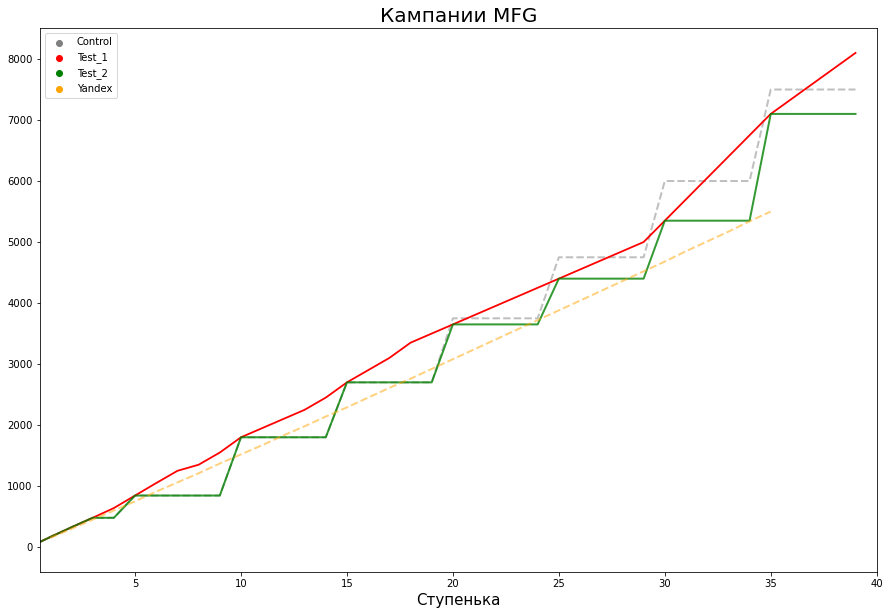

In [44]:
plt.figure(figsize=(15,10))

# plt.plot(list(setup_ladder_control_b.keys())[:40], list(setup_ladder_control_b.values())[:40], '--', c = 'grey', alpha = 0.5, linewidth=2.)
plt.plot(list(setup_ladder_control_nb.keys())[:40], list(setup_ladder_control_nb.values())[:40], '--', c = 'grey', alpha = 0.5, linewidth=2.)

# plt.plot(list(setup_ladder_test1_b.keys())[:40], list(setup_ladder_test1_b.values())[:40], c = 'red', alpha = 1., linewidth=1.8)
plt.plot(list(setup_ladder_test1_nb.keys())[:40], list(setup_ladder_test1_nb.values())[:40], c = 'red', alpha = 1., linewidth=1.8)
    
# plt.plot(list(setup_ladder_test2_b.keys())[:40], list(setup_ladder_test2_b.values())[:40], c = 'green', alpha = 1.8, linewidth=2)
plt.plot(list(setup_ladder_test2_nb.keys())[:40], list(setup_ladder_test2_nb.values())[:40], c = 'green', alpha = 1.8, linewidth=2)

plt.plot(list(new_yandex_nb.keys())[:40], list(new_yandex_nb.values())[:40],  '--', c = 'orange', alpha = .5, linewidth=2.)
# plt.plot(list(suggest_setup_nb.keys())[:40], list(suggest_setup_nb.values())[:40],  '--', c = 'orange', alpha = .5, linewidth=2.)

plt.scatter(0,0, label = 'Control', c='grey')
plt.scatter(0,0, label = 'Test_1', c='red') 
plt.scatter(0,0, label = 'Test_2', c='green')  
plt.scatter(0,0, label = 'Yandex', c='orange') 
plt.xlim(0.5,40)
plt.xlabel('Ступенька', fontsize=15)
# plt.ylabel('Рубли', fontsize=15, rotation=0)
plt.title('Кампании MFG', fontsize=20)


# plt.ylim(1,45)
plt.legend();

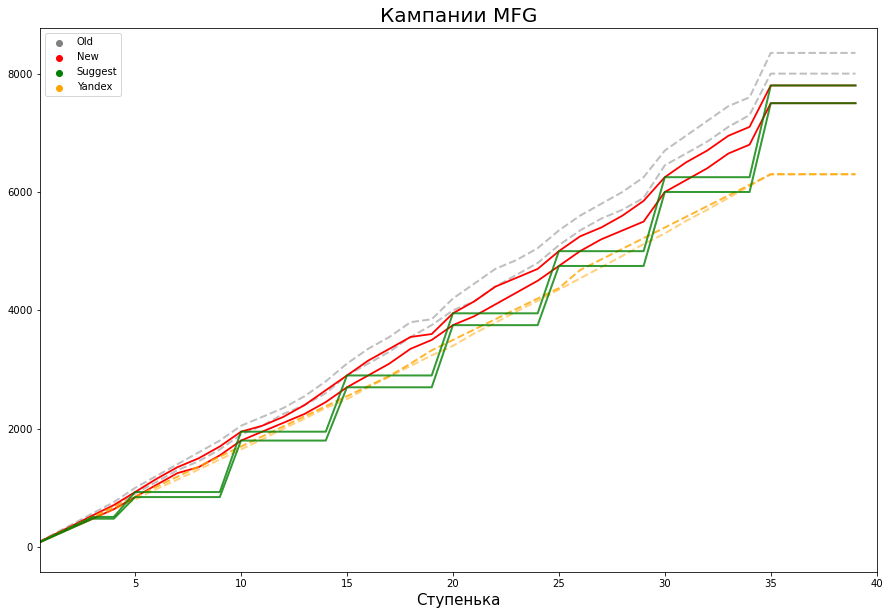

In [45]:
plt.figure(figsize=(15,10))

plt.plot(list(old_setup_b.keys())[:40], list(old_setup_b.values())[:40], '--', c = 'grey', alpha = 0.5, linewidth=2.)
plt.plot(list(old_setup_nb.keys())[:40], list(old_setup_nb.values())[:40], '--', c = 'grey', alpha = 0.5, linewidth=2.)

plt.plot(list(new_setup_b.keys())[:40], list(new_setup_b.values())[:40], c = 'red', alpha = 1., linewidth=1.8)
plt.plot(list(new_setup_nb.keys())[:40], list(new_setup_nb.values())[:40], c = 'red', alpha = 1., linewidth=1.8)
    
plt.plot(list(yandex_nb.keys())[:40], list(yandex_b.values())[:40],  '--', c = 'orange', alpha = .8, linewidth=2.)
plt.plot(list(yandex_b.keys())[:40], list(yandex_nb.values())[:40],  '--', c = 'orange', alpha = .5, linewidth=2.)

plt.plot(list(suggest_setup_b.keys())[:40], list(suggest_setup_b.values())[:40], c = 'green', alpha = 1.8, linewidth=2.)
plt.plot(list(suggest_setup_nb.keys())[:40], list(suggest_setup_nb.values())[:40], c = 'green', alpha = 1.8, linewidth=2.)

plt.scatter(0,0, label = 'Old', c='grey')
plt.scatter(0,0, label = 'New', c='red') 
plt.scatter(0,0, label = 'Suggest', c='green')  
plt.scatter(0,0, label = 'Yandex', c='orange') 
plt.xlim(0.5,40)
plt.xlabel('Ступенька', fontsize=15)
# plt.ylabel('Рубли', fontsize=15, rotation=0)
plt.title('Кампании MFG', fontsize=20)


# plt.ylim(1,45)
plt.legend();

In [46]:
context_data = get_context(date='2021-09-30')

In [47]:
# context_data['SHARE_LONG'] = context_data['SHARE_LONG'] + 0.005
# context_data['AVG_PRICE_LONG'] = context_data['AVG_PRICE_LONG']*1.002
# context_data['AVG_PRICE_SHORT'] = context_data['AVG_PRICE_SHORT']*1.004
# context_data['AVG_PRICE_DRIVER_LONG'] = context_data['AVG_PRICE_DRIVER_LONG']*1.002
# context_data['AVG_PRICE_DRIVER_SHORT'] = context_data['AVG_PRICE_DRIVER_SHORT']*1.004


In [48]:


new_setup_data = generate_data_new(new_setup_ladder, context_data)
old_setup_data = generate_data_new(old_setup_ladder, context_data)
suggest_setup_data = generate_data_new(suggest_setup_ladder, context_data)
yandex_setup_data = generate_data_new(yandex_setup_ladder, context_data)


In [49]:
new_setup_result = calc_ladder(new_setup_data, show_all=True)


RIDES_PREDICT = 5884.0
RIDES = 6523

DRIVERS_PREDICT = 591.0
DRIVERS = 624

TpD_PREDICT = 9.956006768189509
TpD = 10.45352564102564
----------–

GMV_PREDICT = 958494.2339882352
GMV = 1139403.0

FEE_PREDICT = -95976.82274293758
FEE = -161886.0

DI/GMV_PREDICT = -0.10013291612990091
DI/GMV = -0.14207966803668237

DIpT_PREDICT = -16.31149264835785
DIpT = -24.81772190709796

CONTRIBUTION_PREDICT = 65185.180957184755
CONTRIBUTION = -3652.6354

CONTRIBUTION/GMV_PREDICT = 0.06800790098230769
CONTRIBUTION/GMV = -0.00320574493835807


In [50]:
old_setup_result = calc_ladder(old_setup_data, show_all=True)


RIDES_PREDICT = 6171.0
RIDES = 6523

DRIVERS_PREDICT = 591.0
DRIVERS = 624

TpD_PREDICT = 10.441624365482234
TpD = 10.45352564102564
----------–

GMV_PREDICT = 1008755.8675366144
GMV = 1139403.0

FEE_PREDICT = -182855.65113669843
FEE = -161886.0

DI/GMV_PREDICT = -0.18126848826488873
DI/GMV = -0.14207966803668237

DIpT_PREDICT = -29.631445654950323
DIpT = -24.81772190709796

CONTRIBUTION_PREDICT = -11962.995181609895
CONTRIBUTION = -3652.6354

CONTRIBUTION/GMV_PREDICT = -0.011859157965369335
CONTRIBUTION/GMV = -0.00320574493835807


In [51]:
suggest_setup_result = calc_ladder(suggest_setup_data, show_all=True)


RIDES_PREDICT = 5990.0
RIDES = 6523

DRIVERS_PREDICT = 561.0
DRIVERS = 624

TpD_PREDICT = 10.677361853832442
TpD = 10.45352564102564
----------–

GMV_PREDICT = 984719.4447357863
GMV = 1139403.0

FEE_PREDICT = -65265.823645600976
FEE = -161886.0

DI/GMV_PREDICT = -0.06627859741625462
DI/GMV = -0.14207966803668237

DIpT_PREDICT = -10.89579693582654
DIpT = -24.81772190709796

CONTRIBUTION_PREDICT = 100973.38085524726
CONTRIBUTION = -3652.6354

CONTRIBUTION/GMV_PREDICT = 0.10254025285581703
CONTRIBUTION/GMV = -0.00320574493835807


In [52]:
yandex_setup_result = calc_ladder(yandex_setup_data, show_all=True)


RIDES_PREDICT = 5760.0
RIDES = 6523

DRIVERS_PREDICT = 585.0
DRIVERS = 624

TpD_PREDICT = 9.846153846153847
TpD = 10.45352564102564
----------–

GMV_PREDICT = 936853.2672745518
GMV = 1139403.0

FEE_PREDICT = -17420.09176363742
FEE = -161886.0

DI/GMV_PREDICT = -0.018594258431008207
DI/GMV = -0.14207966803668237

DIpT_PREDICT = -3.024321486742608
DIpT = -24.81772190709796

CONTRIBUTION_PREDICT = 139552.22078071578
CONTRIBUTION = -3652.6354

CONTRIBUTION/GMV_PREDICT = 0.14895846089825182
CONTRIBUTION/GMV = -0.00320574493835807


# !OLD! Старая проверка по отложенной выборке (надо чистить, возможно старый код тут)

In [53]:
control_date = '2021-09-28'

In [54]:
# data_control
data_control_1 = data_control_0[data_control_0['DATE']==control_date].copy()

data_control_1.loc[:,'PREDICT_FLAG'] = np.floor(model_cl.predict(data_control_1[columns_list]))

data_control = data_control_1[data_control_1['PREDICT_FLAG']!=10]

# data_control.loc[:,'PREDICT'] = model.predict(data_control[columns_list])
# data_control['PREDICT'] = (data_control['PREDICT'] - data_control['PREDICT']%data_control['ORDERS_COUNT'])/ data_control['ORDERS_COUNT']

data_control.loc[:,'PREDICT'] = data_control_1['PREDICT_FLAG']*(model.predict(data_control[columns_list])/ data_control['ORDERS_COUNT'])

data_control.loc[:,'PREDICT'] = (data_control.loc[:,'PREDICT']/data_control.loc[:,'PREDICT'].sum()) * data_control['ACTIVE_DRIVERS']

data_control.loc[:,'DRIVER_BILL_PREDICT'] = np.floor(model_bill.predict(data_control[columns_bill_list])) #* (data_control['PREDICT'].apply(lambda x: 1 if x>0 else 0))


data_control['FEE_PREDICT'] = (data_control['EXPECTED_SUM'] - data_control['DRIVER_BILL_PREDICT'])*data_control['PREDICT']
data_control['FEE_PREDICT'] = data_control['FEE_PREDICT'].apply(lambda x: 0 if x<0 else x)

data_control['PREDICT'] = np.floor(data_control['PREDICT']) #костыль с округлением

data_control['SHARE_LONG_STEP'] = np.round(m2.predict(np.array(data_control['ORDERS_COUNT']).reshape(-1,1)),3)

data_control['GMV_PREDICT'] = ((np.floor(data_control['ORDERS_COUNT']*(data_control['SHARE_LONG_STEP']))* (data_control['AVG_PRICE_LONG'])) 
                                + (np.floor(data_control['ORDERS_COUNT']*(1-data_control['SHARE_LONG_STEP']))* (data_control['AVG_PRICE_SHORT'])))* data_control['PREDICT']



In [55]:

print('MFG. 28.09.21\n')
print('DRIVER_BILL =',data_control[data_control['ORDERS_COUNT']<50]['DRIVER_BILL'].median())
print('DRIVER_BILL_PREDICT =',data_control[data_control['ORDERS_COUNT']<50]['DRIVER_BILL_PREDICT'].median())

print('\nGMV = 1046663 [SQL-запрос]')
print('GMV_PREDICT =',data_control['GMV_PREDICT'].sum())

print('\nORDERS = 6591 [SQL-запрос]')
print('ORDERS_PREDICT =',(data_control['ORDERS_COUNT']* data_control['PREDICT']).sum())

print('\nFEE =',-data_control['FEE'].sum())
print('FEE_PREDICT =',-data_control['FEE_PREDICT'].sum())

print('\nFEE/GMV =',-data_control['FEE'].sum()/1046663)
print('FEE_PREDICT/GMV_PREDICT =',-data_control['FEE_PREDICT'].sum()/data_control['GMV_PREDICT'].sum())

print('\nDRIVERS =', data_control['DRIVER_ID'].sum())
print('DRIVERS_PREDICT =', data_control['PREDICT'].sum())

print('\nTpD =', (data_control['ORDERS_COUNT']*data_control['DRIVER_ID']).sum()/data_control['DRIVER_ID'].sum())
print('TpD_PREDICT =', (data_control['ORDERS_COUNT']*data_control['PREDICT']).sum()/data_control['PREDICT'].sum())


MFG. 28.09.21

DRIVER_BILL = 0.0
DRIVER_BILL_PREDICT = 4073.0

GMV = 1046663 [SQL-запрос]
GMV_PREDICT = 955628.9348721782

ORDERS = 6591 [SQL-запрос]
ORDERS_PREDICT = 6197.0

FEE = -291572.0
FEE_PREDICT = -230574.49476259548

FEE/GMV = -0.27857295041479446
FEE_PREDICT/GMV_PREDICT = -0.24128036139198356

DRIVERS = 669.0
DRIVERS_PREDICT = 615.0

TpD = 9.856502242152466
TpD_PREDICT = 10.076422764227642


In [56]:
control_date = '2021-09-28'
context_data_control = get_context(date=control_date)
context_data_control.head()

,DATE,ORDERS,ACTIVE_DRIVERS,SHARE_LONG,AVG_PRICE_LONG,AVG_PRICE_SHORT,AVG_PRICE_DRIVER_LONG,AVG_PRICE_DRIVER_SHORT,GMV,RIDES,COMMISSION,OTHER_I,CONTRIBUTION,DRIVER_ID,FEE,DRIVER_BILL,TPD,IS_WEEKEND
0,2021-09-28,9991,699,0.448103,240.453429,121.027385,224.706294,130.172105,1078364.0,6682,0.2217,15712.88,-115393.0681,669,291572.0,1214.0,9.856502,0


In [57]:

print('MFG. 28.09.21\n')
print('DRIVER_BILL =',data_control[data_control['ORDERS_COUNT']<50]['DRIVER_BILL'].median())
print('DRIVER_BILL_PREDICT =',data_control[data_control['ORDERS_COUNT']<50]['DRIVER_BILL_PREDICT'].median())

print('\nGMV =', (context_data_control['GMV'].values[0]))
print('GMV_PREDICT =',data_control['GMV_PREDICT'].sum())

print('\nORDERS =', (context_data_control['RIDES'].values[0]))
print('ORDERS_PREDICT =',(data_control['ORDERS_COUNT']* data_control['PREDICT']).sum())

print('\nFEE =',-data_control['FEE'].sum())
print('FEE_PREDICT =',-data_control['FEE_PREDICT'].sum())

print('\nDIpT =',-data_control['FEE'].sum() / (data_control['ORDERS_COUNT']*data_control['DRIVER_ID']).sum())
print('DIpT_PREDICT =',-data_control['FEE_PREDICT'].sum() / (data_control['ORDERS_COUNT']*data_control['PREDICT']).sum())

print('\nCntr/GMV =',((context_data_control['GMV'].values[0]*0.192)-data_control['FEE'].sum())/context_data_control['GMV'].values[0])
print('Cntr_PREDICT/GMV_PREDICT =',((data_control['GMV_PREDICT'].sum()*0.192)-data_control['FEE_PREDICT'].sum())/data_control['GMV_PREDICT'].sum())

print('\nDRIVERS =', data_control['DRIVER_ID'].sum())
print('DRIVERS_PREDICT =', data_control['PREDICT'].sum())

print('\nTpD =', (data_control['ORDERS_COUNT']*data_control['DRIVER_ID']).sum()/data_control['DRIVER_ID'].sum())
print('TpD_PREDICT =', (data_control['ORDERS_COUNT']*data_control['PREDICT']).sum()/data_control['PREDICT'].sum())


MFG. 28.09.21

DRIVER_BILL = 0.0
DRIVER_BILL_PREDICT = 4073.0

GMV = 1078364.0
GMV_PREDICT = 955628.9348721782

ORDERS = 6682
ORDERS_PREDICT = 6197.0

FEE = -291572.0
FEE_PREDICT = -230574.49476259548

DIpT = -44.2177737336973
DIpT_PREDICT = -37.207438238275856

Cntr/GMV = -0.07838365524071648
Cntr_PREDICT/GMV_PREDICT = -0.049280361391983545

DRIVERS = 669.0
DRIVERS_PREDICT = 615.0

TpD = 9.856502242152466
TpD_PREDICT = 10.076422764227642


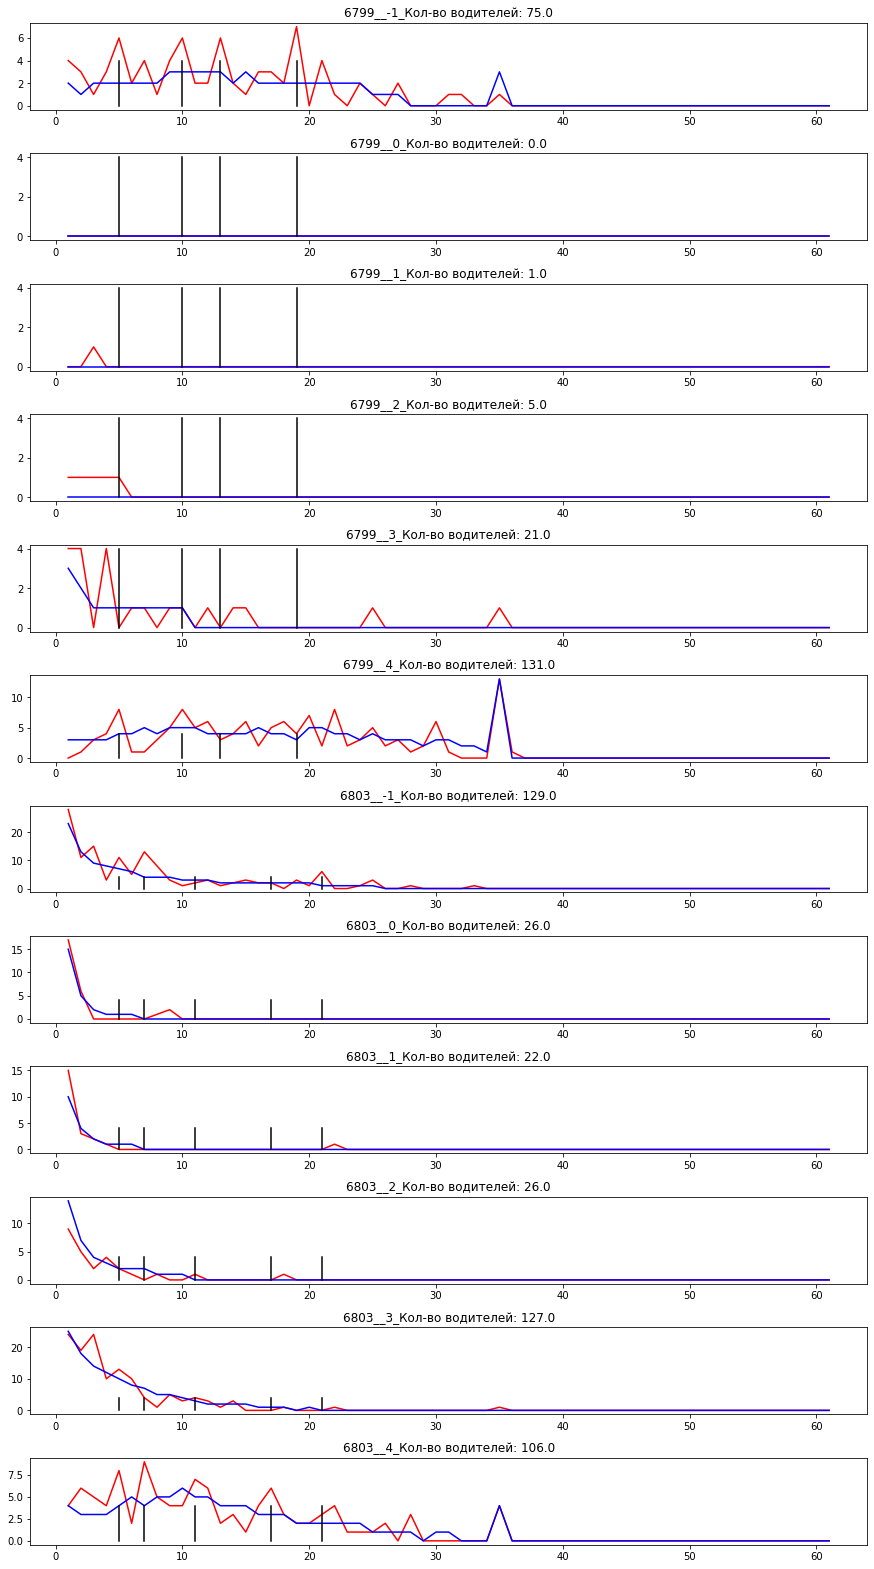

In [58]:
# fig = plt.figure(figsize=(15,28))
fig = matplotlib.pyplot.figure(figsize=(15,28))
gs1 = fig.add_gridspec(nrows=12, ncols=3, wspace=0.2, hspace=0.5)
k = 1
for j in data_control['SURCHARGE_ID'].unique():
    temp = data_control[data_control['SURCHARGE_ID']==j]
    for i in temp['SEGMENT_ID'].unique():
        ax = fig.add_subplot(gs1[k-1:k,0:3])
        ax.plot(temp[temp['SEGMENT_ID']==i]['ORDERS_COUNT'], temp[temp['SEGMENT_ID']==i]['DRIVER_ID'], color = 'red')
        ax.plot(temp[temp['SEGMENT_ID']==i]['ORDERS_COUNT'], temp[temp['SEGMENT_ID']==i]['PREDICT'], color = 'blue')
#         ax.plot([20,20],[0,4], color = 'black')
        if j == 6799:
            ax.plot([5,5],[0,4], color = 'black')
            ax.plot([10,10],[0,4], color = 'black')
            ax.plot([13,13],[0,4], color = 'black')
            ax.plot([19,19],[0,4], color = 'black')
        else:
            ax.plot([5,5],[0,4], color = 'black')
            ax.plot([7,7],[0,4], color = 'black')
            ax.plot([11,11],[0,4], color = 'black')
            ax.plot([17,17],[0,4], color = 'black')
            ax.plot([21,21],[0,4], color = 'black')


        k = k + 1
        ax.set_title(str(j)+'__'+str(i) + '_Кол-во водителей: ' +str(temp[temp['SEGMENT_ID']==i]['DRIVER_ID'].sum()))